In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyplr.stlabhelp import get_led_colors
from pysilsub.problems import SilentSubstitutionProblem as SSP
from pyplr import stlabhelp

# STLAB calibrations

In [2]:
S1 = SSP.from_json('/Users/jtm545/Projects/BakerWadeBBSRC/data/STLAB_1_York.json')
S2 = SSP.from_json('/Users/jtm545/Projects/BakerWadeBBSRC/data/STLAB_2_York.json')
S1.do_gamma()
S2.do_gamma()

# Spectra comparison

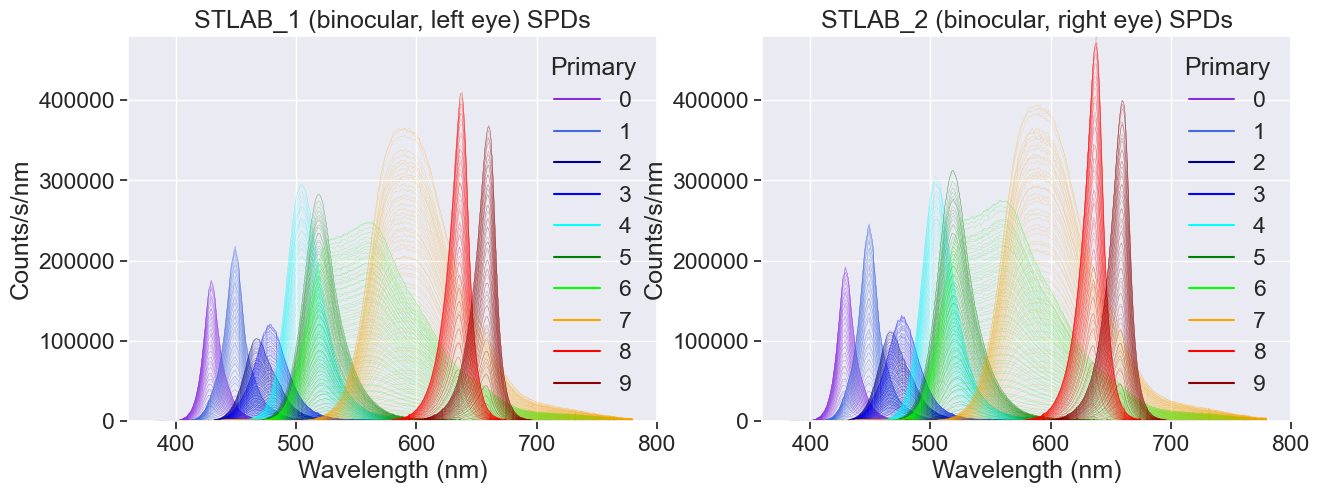

In [3]:
plt.style.use('seaborn-darkgrid')
sns.set_context('notebook', font_scale=1.5)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

S1.plot_calibration_spds(ax=axs[0])
S2.plot_calibration_spds(ax=axs[1])

ymax = max([S1.calibration.max().max(), S2.calibration.max().max()])

for ax in axs:
    ax.set_ylim((0, ymax))

# $\lambda$-max comparison

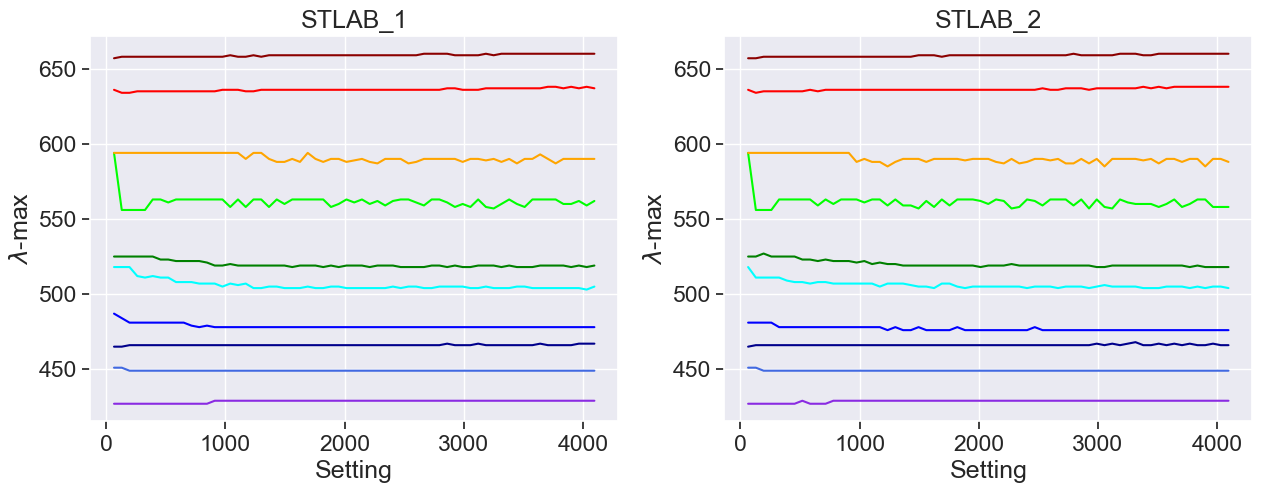

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

S1_lmax = S1.calibration.idxmax(axis=1)
S2_lmax = S2.calibration.idxmax(axis=1)

leds = range(0, 10)

for led, color in zip(leds, get_led_colors()):
    axs[0].plot(S1_lmax.loc[led][1:], c=color)
    axs[1].plot(S2_lmax.loc[led][1:], c=color)

axs[0].set_title('STLAB_1')
axs[1].set_title('STLAB_2')

for ax in axs:
    ax.set_ylabel('$\lambda$-max')
    ax.set_xlabel('Setting')

# Max counts comparison

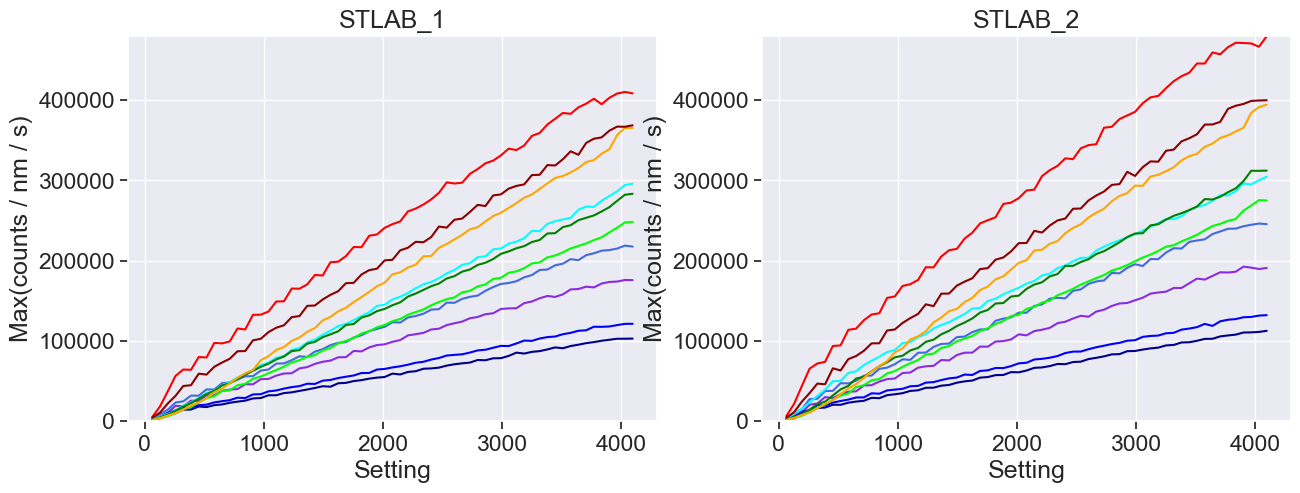

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

S1_max = S1.calibration.max(axis=1)
S2_max = S2.calibration.max(axis=1)

leds = range(0, 10)

ymax = max([S1_max.max(), S2_max.max()])

for led, color in zip(leds, get_led_colors()):
    axs[0].plot(S1_max.loc[led][1:], c=color)
    axs[1].plot(S2_max.loc[led][1:], c=color)
    
axs[0].set_title('STLAB_1')
axs[1].set_title('STLAB_2')

for ax in axs:
    ax.set_ylabel('Max(counts / nm / s)')
    ax.set_xlabel('Setting')
    ax.set_ylim((0, ymax))

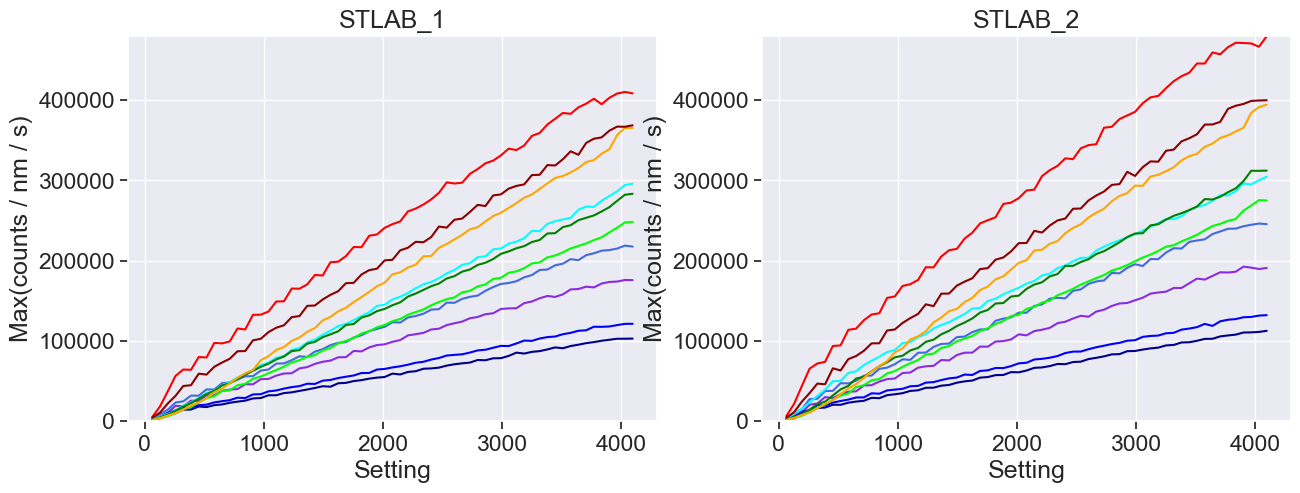

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

S1_max = S1.calibration.max(axis=1)
S2_max = S2.calibration.max(axis=1)

leds = range(0, 10)

ymax = max([S1_max.max(), S2_max.max()])

for led, color in zip(leds, get_led_colors()):
    axs[0].plot(S1_max.loc[led][1:], c=color)
    axs[1].plot(S2_max.loc[led][1:], c=color)
    
axs[0].set_title('STLAB_1')
axs[1].set_title('STLAB_2')

for ax in axs:
    ax.set_ylabel('Max(counts / nm / s)')
    ax.set_xlabel('Setting')
    ax.set_ylim((0, ymax))

# Half-max comparison

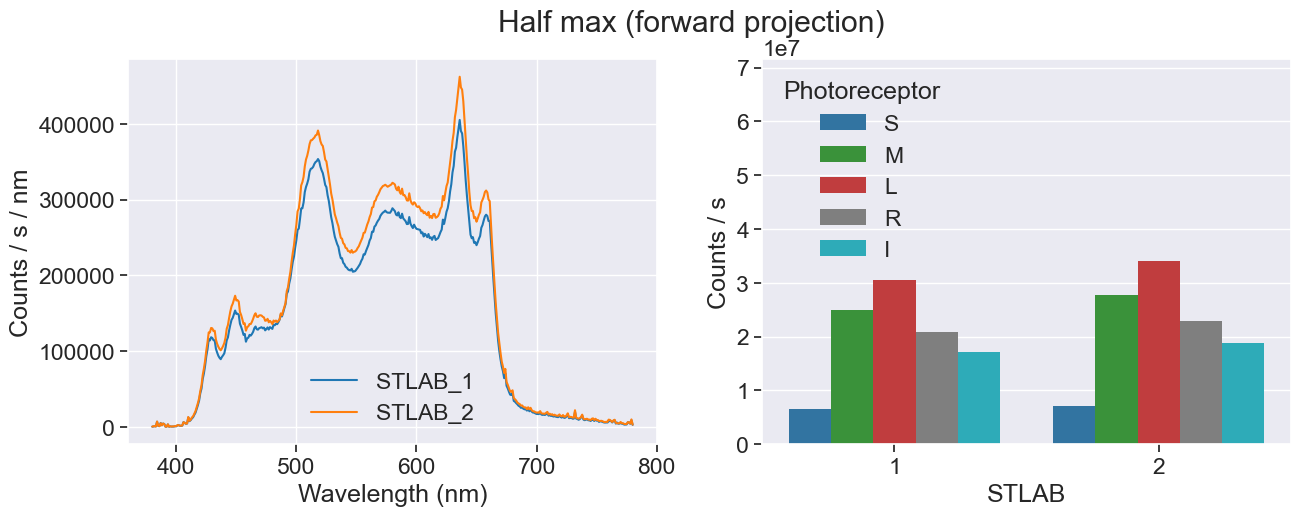

In [7]:
halfmax = [.5]*10

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

bg1 = S1.predict_multiprimary_spd(halfmax).plot(label='STLAB_1', ax=axs[0])
bg2 = S2.predict_multiprimary_spd(halfmax).plot(label='STLAB_2', ax=axs[0])
axs[0].legend()

bg1a = S1.predict_multiprimary_aopic(halfmax).to_frame().reset_index()
bg2a = S2.predict_multiprimary_aopic(halfmax).to_frame().reset_index()
bg1a['STLAB'] = 1
bg2a['STLAB'] = 2
for df in [bg1a, bg2a]:
    df.rename(columns={'index': 'Photoreceptor'}, inplace=True)
bgs = (pd.concat([bg1a, bg2a], axis=0)
       .melt(id_vars=['Photoreceptor', 'STLAB']))

sns.barplot(x='STLAB', y='value', 
            hue='Photoreceptor', units='STLAB', 
            palette=S1.photoreceptor_colors, 
            data=bgs)

fig.suptitle('Half max (forward projection)');

axs[0].set_ylabel('Counts / s / nm')
axs[0].set_xlabel('Wavelength (nm)')

axs[1].set_ylabel('Counts / s')
axs[1].set_ylim((0, axs[1].get_ylim()[1]*2))
fig.savefig('STLAB_1_2_halfmax.jpg')

# Binocular STLAB modulations

1 Hz sinusoidal contrast modulations for each photoreceptor with maximum available contrast against the same background.

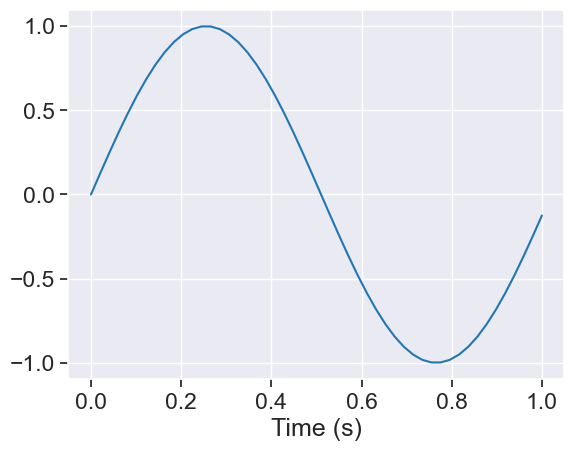

In [8]:
photoreceptors = S1.photoreceptors
colors = S1.photoreceptor_colors.values()

# Create sinusoidal stimulus profile
sinusoid = stlabhelp.sinusoid_modulation(
    f=1, duration=1, Fs=50)
time = np.linspace(0,1,50)
plt.plot(time, sinusoid)
plt.xlabel('Time (s)');

## S-cone

In [9]:
for problem in [S1, S2]:
    problem.ignore = ['R']
    problem.modulate = ['S']
    problem.minimize = ['M', 'L', 'I']
    problem.target_contrast = 0.
    problem.background = [.5] * problem.nprimaries

In [10]:
peak_contrast = .2
contrast_waveform = sinusoid * peak_contrast

S1_solutions = []
S2_solutions = []
for target_contrast in contrast_waveform:
    S1.target_contrast = target_contrast
    S2.target_contrast = target_contrast
    S1_solutions.append(S1.linalg_solve())
    S2_solutions.append(S2.linalg_solve())

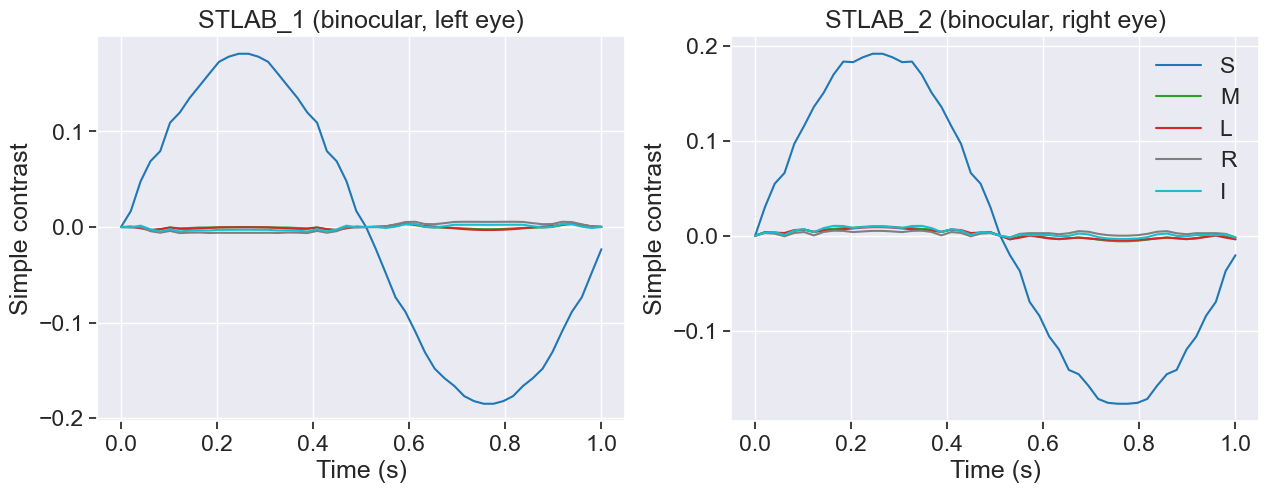

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for ax, device, solutions in zip(axs, [S1, S2], [S1_solutions, S2_solutions]):
    splatter = [device.get_photoreceptor_contrasts(s) for s in solutions]
    splatter = np.vstack(splatter)
    
    for idx, (p, c) in enumerate(zip(photoreceptors, colors)):
        
        ax.plot(time, splatter[:, idx], label=p, color=c)
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(device.name)
    ax.set_xlabel('Time (s)')
    
plt.legend()

## Melanopsin

In [12]:
for problem in [S1, S2]:
    problem.ignore = ['R']
    problem.modulate = ['I']
    problem.minimize = ['S', 'M', 'L']
    problem.target_contrast = 0.
    problem.background = [.5] * problem.nprimaries

In [13]:
peak_contrast = .1
contrast_waveform = sinusoid * peak_contrast

S1_solutions = []
S2_solutions = []
for target_contrast in contrast_waveform:
    S1.target_contrast = target_contrast
    S2.target_contrast = target_contrast
    S1_solutions.append(S1.linalg_solve())
    S2_solutions.append(S2.linalg_solve())

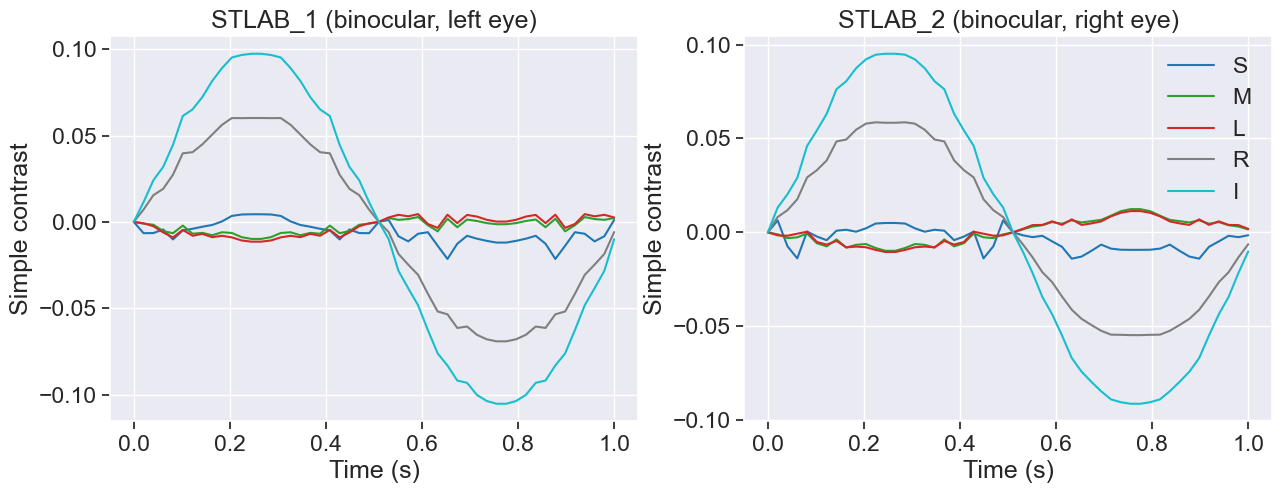

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for ax, device, solutions in zip(axs, [S1, S2], [S1_solutions, S2_solutions]):
    solutions = [device.gamma_correct((s*4095).astype('int')) for s in solutions]
    device.background = solutions[0]
    splatter = [device.get_photoreceptor_contrasts(s) for s in solutions]
    splatter = np.vstack(splatter)

    for idx, (p, c) in enumerate(zip(photoreceptors, colors)):
        
        ax.plot(time, splatter[:, idx], label=p, color=c)
    
    ax.set_ylabel('Simple contrast')
    ax.set_title(device.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

## M-cone

In [15]:
for problem in [S1, S2]:
    problem.ignore = ['R']
    problem.modulate = ['M']
    problem.minimize = ['S', 'L', 'I']
    problem.target_contrast = 0.
    problem.background = [.5] * problem.nprimaries

In [16]:
peak_contrast = .1
contrast_waveform = sinusoid * peak_contrast

S1_solutions = []
S2_solutions = []
for target_contrast in contrast_waveform:
    S1.target_contrast = target_contrast
    S2.target_contrast = target_contrast
    S1_solutions.append(S1.linalg_solve())
    S2_solutions.append(S2.linalg_solve())

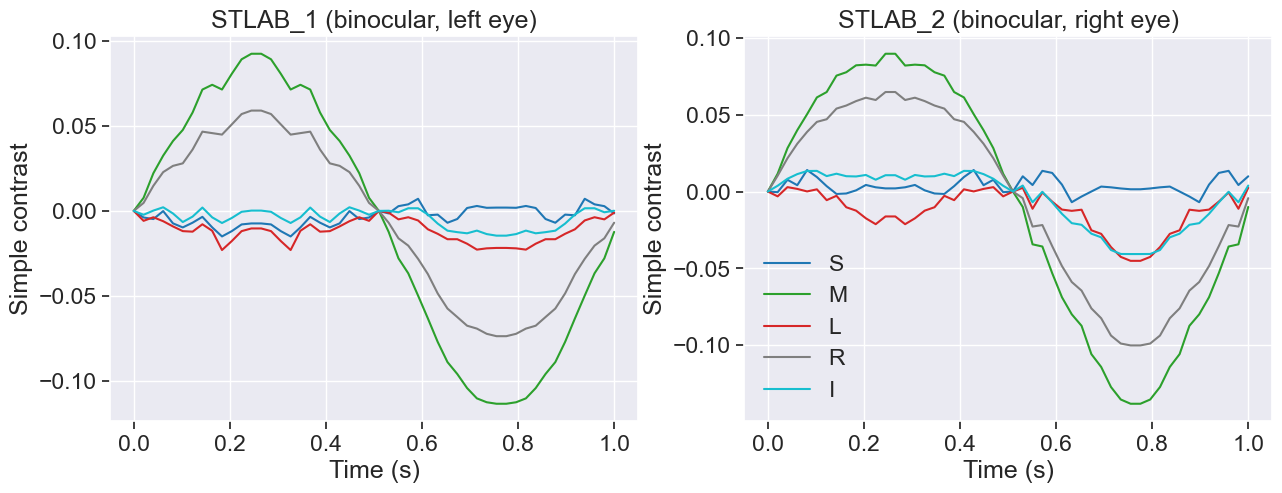

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for ax, device, solutions in zip(axs, [S1, S2], [S1_solutions, S2_solutions]):
    #solutions = [device.gamma_correct((s*4095).astype('int')) for s in solutions]
    #device.background = solutions[0]
    splatter = [device.get_photoreceptor_contrasts(s) for s in solutions]
    splatter = np.vstack(splatter)
    
    for idx, (p, c) in enumerate(zip(photoreceptors, colors)):
        
        ax.plot(time, splatter[:, idx], label=p, color=c)
    
    ax.set_ylabel('Simple contrast')
    ax.set_title(device.name)
    ax.set_xlabel('Time (s)')
    
plt.legend()

## L-cone

In [18]:
for problem in [S1, S2]:
    problem.ignore = ['R']
    problem.modulate = ['L']
    problem.minimize = ['S', 'M', 'I']
    problem.target_contrast = 0.
    problem.background = [.5] * problem.nprimaries

In [19]:
peak_contrast = .13
contrast_waveform = sinusoid * peak_contrast

S1_solutions = []
S2_solutions = []
for target_contrast in contrast_waveform:
    S1.target_contrast = target_contrast
    S2.target_contrast = target_contrast
    S1_solutions.append(S1.linalg_solve())
    S2_solutions.append(S2.linalg_solve())

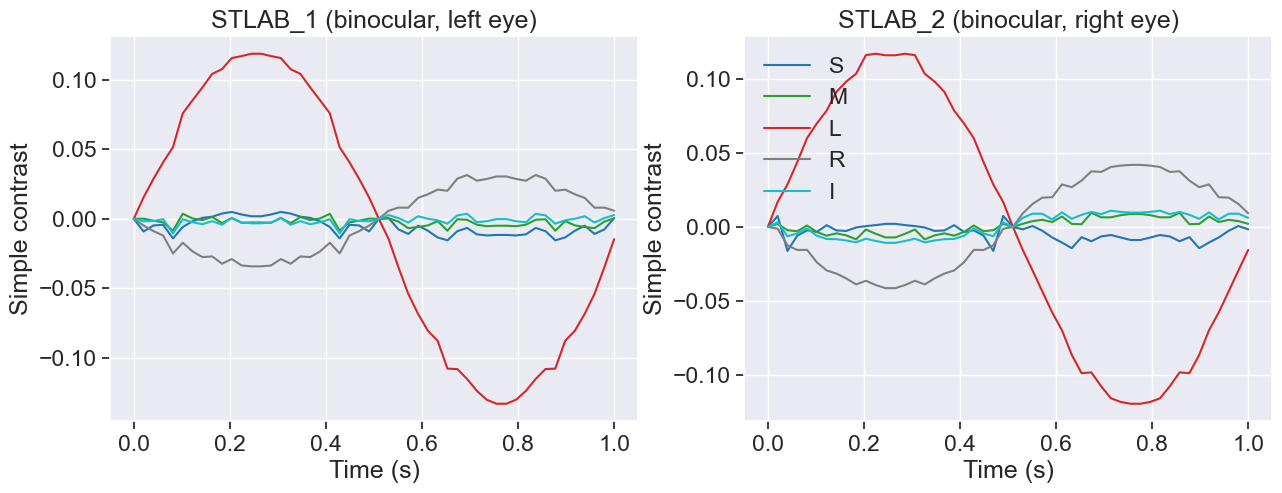

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for ax, device, solutions in zip(axs, [S1, S2], [S1_solutions, S2_solutions]):
    solutions = [device.gamma_correct((s*4095).astype('int')) for s in solutions]
    device.background = solutions[0]
    splatter = [device.get_photoreceptor_contrasts(s) for s in solutions]
    splatter = np.vstack(splatter)
    
    for idx, (p, c) in enumerate(zip(photoreceptors, colors)):
        
        ax.plot(time, splatter[:, idx], label=p, color=c)
    
    ax.set_ylabel('Simple contrast')
    ax.set_title(device.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

# Testing gamma correction...

In [21]:
for problem in [S1, S2]:
    problem.ignore = ['R']
    problem.modulate = ['L']
    problem.minimize = ['S', 'I', 'M']
    problem.target_contrast = 0.
    problem.background = [.5] * 10

In [22]:
peak_contrast = .12
contrast_waveform = sinusoid * peak_contrast

S1_solutions = []
S2_solutions = []
for target_contrast in contrast_waveform:
    S1.target_contrast = target_contrast
    S2.target_contrast = target_contrast
    S1_solutions.append(S1.linalg_solve())
    S2_solutions.append(S2.linalg_solve())

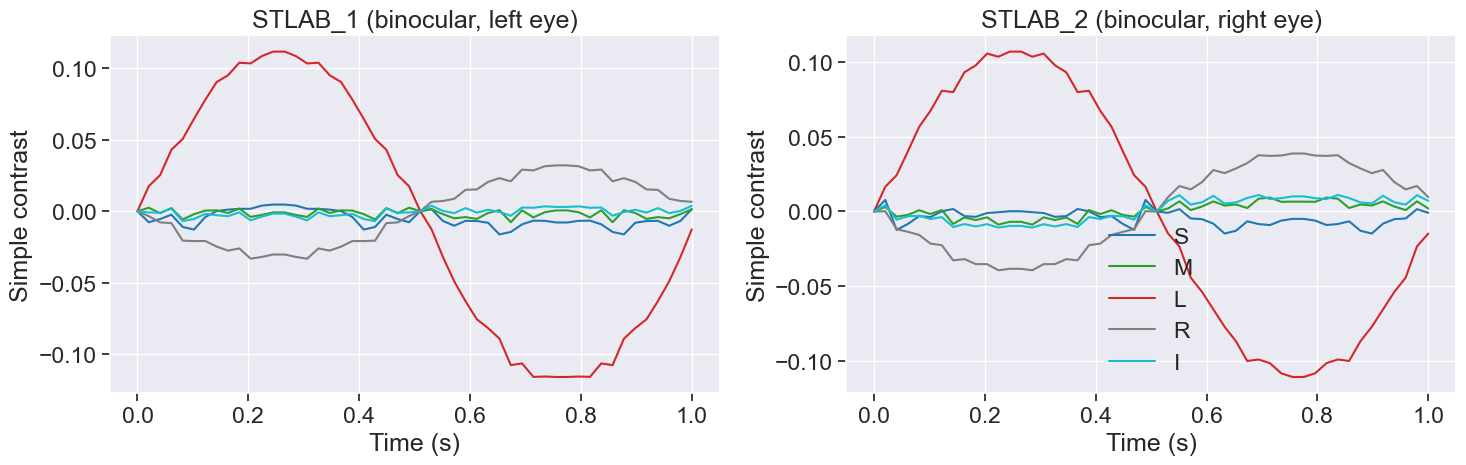

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for ax, device, solutions in zip(axs, [S1, S2], [S1_solutions, S2_solutions]):
    solutions = [device.gamma_correct((s*4095).astype('int')) for s in solutions]
    # !
    device.background = solutions[0]
    splatter = [device.get_photoreceptor_contrasts(s) for s in solutions]
    splatter = np.vstack(splatter)
    
    for idx, (p, c) in enumerate(zip(photoreceptors, colors)):
        
        ax.plot(time, splatter[:, idx], label=p, color=c)
    
    ax.set_ylabel('Simple contrast')
    ax.set_title(device.name)
    ax.set_xlabel('Time (s)')
    
plt.legend()
plt.tight_layout();